In [2]:
import os
import shutil

# 1. SETUP KEY
if not os.path.exists('kaggle.json'):
    print(" STOP: Upload 'kaggle.json' to the file sidebar first.")
else:
    if not os.path.exists("/root/.kaggle"):
        os.makedirs("/root/.kaggle")
    shutil.copy('kaggle.json', '/root/.kaggle/kaggle.json')
    !chmod 600 /root/.kaggle/kaggle.json
    print(" Key configured.")

    # 2. DOWNLOAD THE 'READY-TO-USE' DATASET
    # This dataset is already organized and fits in Colab
    print("⬇Downloading Pre-Sorted Pneumonia Dataset...")
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

    # 3. UNZIP
    print("📦 Unzipping...")
    !unzip -q -o chest-xray-pneumonia.zip

    print(" DONE! Look at your file sidebar.")
    print("You should see a folder named 'chest_xray'.")

 Key configured.
⬇Downloading Pre-Sorted Pneumonia Dataset...
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.26G/2.29G [00:22<00:00, 91.8MB/s]
100% 2.29G/2.29G [00:22<00:00, 110MB/s] 
📦 Unzipping...
 DONE! Look at your file sidebar.
You should see a folder named 'chest_xray'.


In [3]:
import os
import time
import copy
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, models, transforms

from sklearn.metrics import roc_auc_score, confusion_matrix

# -------------------------
# Configurable settings
# -------------------------
TRAIN_PATH = "chest_xray/train"
VAL_PATH = "chest_xray/test"
MODEL_OUT = "pneumonia_model.pth"
NUM_EPOCHS = 3
BATCH_SIZE = 32
LR = 1e-4
PATIENCE = 2
NUM_WORKERS = min(4, max(1, (os.cpu_count() or 2) - 1))
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Utility: reproducibility
# -------------------------
def set_seed(seed: int = SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# -------------------------
# Transforms
# -------------------------
def build_transforms():
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.05, contrast=0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    return train_transforms, val_transforms

# -------------------------
# Dataloaders
# -------------------------
def build_dataloaders(train_path, val_path, batch_size):
    train_transform, val_transform = build_transforms()
    train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_path, transform=val_transform)

    targets = [label for _, label in train_dataset.imgs]
    class_counts = np.bincount(targets)
    class_weights = 1.0 / (class_counts + 1e-8)
    sample_weights = np.array([class_weights[t] for t in targets])
    sampler = WeightedRandomSampler(torch.DoubleTensor(sample_weights),
                                    num_samples=len(sample_weights),
                                    replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,
                              num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=NUM_WORKERS, pin_memory=True)

    return (
        {'train': train_loader, 'val': val_loader},
        {'train': len(train_dataset), 'val': len(val_dataset)},
        train_dataset.classes
    )

# -------------------------
# Model builder
# -------------------------
def build_model(num_classes, freeze_backbone=True):
    model = models.resnet50(pretrained=True)
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    return model

# -------------------------
# Training
# -------------------------
def train(model, dataloaders, dataset_sizes, device, num_epochs):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)

    best_auc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_count = 0

    for epoch in range(num_epochs):
        print("="*40)
        print(f"Epoch {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_labels, all_probs = [], []

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    probs = torch.softmax(outputs, 1)[:, 1]
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels).item()
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.detach().cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            try:
                epoch_auc = roc_auc_score(all_labels, all_probs)
            except ValueError:
                epoch_auc = float('nan')

            print(f"[{phase}] Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}  AUC: {epoch_auc}")

            if phase == "val":
                scheduler.step(epoch_auc if not np.isnan(epoch_auc) else 0.0)

                if not np.isnan(epoch_auc) and epoch_auc > best_auc:
                    best_auc = epoch_auc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, MODEL_OUT)
                    print(f"✔ Best model saved → {MODEL_OUT} (AUC={best_auc:.4f})")
                    patience_count = 0
                else:
                    patience_count += 1
                    print(f"No improvement: {patience_count}/{PATIENCE}")

        if patience_count >= PATIENCE:
            print("Early stopping triggered.")
            break

    model.load_state_dict(best_model_wts)
    print(f"Training done. Best AUC = {best_auc:.4f}")
    return model

# -------------------------
# MAIN
# -------------------------
def main():
    print("Starting clean training script...")
    set_seed()
    print("Device:", DEVICE)

    dataloaders, dataset_sizes, class_names = build_dataloaders(TRAIN_PATH, VAL_PATH, BATCH_SIZE)
    print("Classes:", class_names)
    print("Sizes:", dataset_sizes)

    model = build_model(num_classes=len(class_names))
    model = train(model, dataloaders, dataset_sizes, DEVICE, NUM_EPOCHS)

    print("Model saved as:", MODEL_OUT)

if __name__ == "__main__":
    main()


Starting clean training script...
Device: cuda
Classes: ['NORMAL', 'PNEUMONIA']
Sizes: {'train': 5216, 'val': 624}


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


Epoch 1/3
[train] Loss: 0.3191  Acc: 0.8750  AUC: 0.9506099110098023
[val] Loss: 0.3333  Acc: 0.8702  AUC: 0.9323252246329171
✔ Best model saved → pneumonia_model.pth (AUC=0.9323)
Epoch 2/3
[train] Loss: 0.2070  Acc: 0.9199  AUC: 0.9742764379828874
[val] Loss: 0.4035  Acc: 0.8381  AUC: 0.9311308349769888
No improvement: 1/2
Epoch 3/3
[train] Loss: 0.1835  Acc: 0.9293  AUC: 0.9790791847805632
[val] Loss: 0.3326  Acc: 0.8478  AUC: 0.934045584045584
✔ Best model saved → pneumonia_model.pth (AUC=0.9340)
Training done. Best AUC = 0.9340
Model saved as: pneumonia_model.pth


Classes: ['NORMAL', 'PNEUMONIA']


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully!

===== FINAL EVALUATION =====
Accuracy: 0.8478
AUC: 0.9340
Confusion Matrix:
[[172  62]
 [ 33 357]]


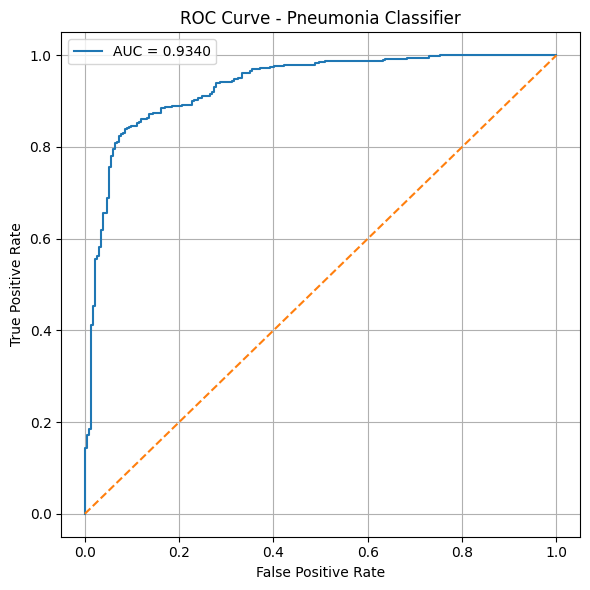

ROC curve saved as roc_curve.png


In [4]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import (
    confusion_matrix, roc_curve, roc_auc_score, accuracy_score
)
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# CONFIG
# -------------------------
VAL_PATH = "chest_xray/test"
MODEL_PATH = "pneumonia_model.pth"
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# TRANSFORMS (same as validation)
# -------------------------
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# -------------------------
# LOAD DATASET
# -------------------------
val_dataset = datasets.ImageFolder(VAL_PATH, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = val_dataset.classes
print("Classes:", class_names)

# -------------------------
# LOAD MODEL
# -------------------------
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 2)
)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

print("Model loaded successfully!")

# -------------------------
# EVALUATION LOOP
# -------------------------
all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]   # probability of pneumonia
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert to arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_preds = np.array(all_preds)

# -------------------------
# METRICS
# -------------------------
acc = accuracy_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, all_preds)

print("\n===== FINAL EVALUATION =====")
print(f"Accuracy: {acc:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

# -------------------------
# ROC CURVE (Optional Plot)
# -------------------------
fpr, tpr, _ = roc_curve(all_labels, all_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Pneumonia Classifier")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve.png")
plt.show()

print("ROC curve saved as roc_curve.png")
